In [59]:
import numpy as np
import torch

# numpy 출력 형식 지정
np.set_printoptions(precision=4, linewidth=150)

## Forward 1 step

- numpy만 사용해서 rnn cell을 한 스탭 포워드 시키기

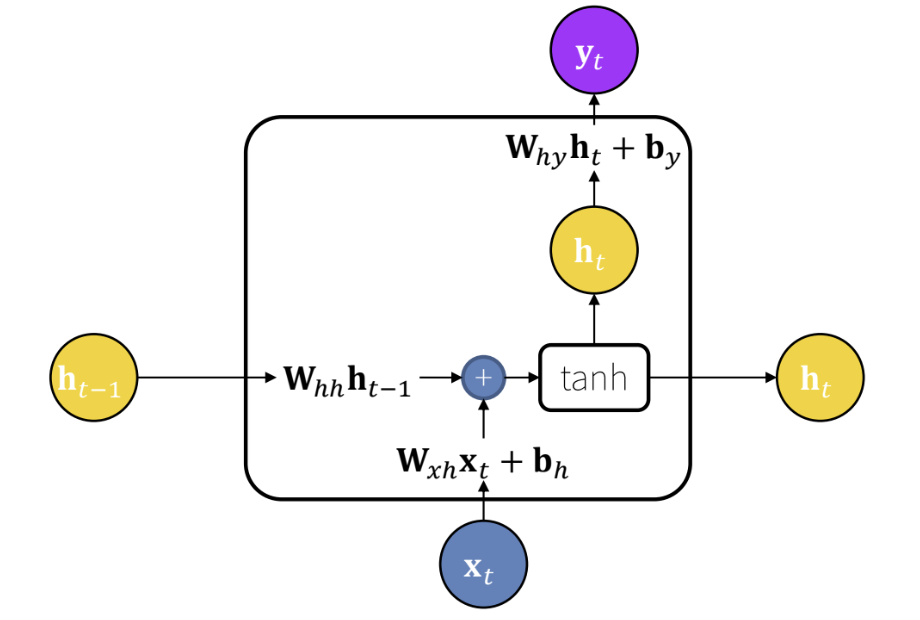

In [60]:
# 입력 벡터 사이즈 5
x_size = 5

# 히든 벡터 사이즈 10 (rnn cell의 출력 크기)
hidden_size = 10 # h_t

# 출력(예측)벡터 사이즈 15 (rnn cell의 출력을 최종 출력으로 바꾼 벡터의 크기)
y_size = 15 # y_t

In [61]:
np.random.seed(10)

# 각 벡터와 곱해질 웨이트와 바이어스 초기화
# 입력을 열벡터로 사용하기 때문에 W의 모양은 (output, input)이 됨을 주의
Wxh = np.random.randn(hidden_size, x_size).astype(np.float32)
bh = np.random.randn(hidden_size).astype(np.float32)
Whh = np.random.randn(hidden_size, hidden_size).astype(np.float32)
Why = np.random.randn(y_size, hidden_size).astype(np.float32)
by = np.random.randn(y_size).astype(np.float32)
print('Wxh: ', Wxh.shape, 'bh: ', bh.shape)
print('Whh: ', Whh.shape)
print('Why: ', Why.shape, 'by: ', by.shape)
print()

# 입력벡터 초기화, (step, x_size)인 one-hot vector
x = np.zeros((1, x_size), dtype=np.float32)
x[0,2] = 1
# x = [[0. 0. 1. 0. 0.]] 와 같은 형태
# ex) "나는 너를 사랑해" 라는 문장에서 "나는"은 x의 3번째 단어.
# 원핫 인코딩과 같이 문장의 단어를 원 - 핫...


print(f"x(x0): {x_size}-dim. vector, one step ")
print(x)

# 이전 상태 벡터 초기화
hprev = np.random.randn(1, hidden_size).astype(np.float32)
print(f"h_prev(h-1): {hidden_size}-dim.")
print(hprev)

Wxh:  (10, 5) bh:  (10,)
Whh:  (10, 10)
Why:  (15, 10) by:  (15,)

x(x0): 5-dim. vector, one step 
[[0. 0. 1. 0. 0.]]
h_prev(h-1): 10-dim.
[[ 0.2098 -0.8912 -0.7827  1.0797 -0.4628 -1.5151 -0.5387  0.7566 -0.7294  1.2148]]


### 직접 포워드

In [62]:
Wxh.T

array([[ 1.3316, -0.7201,  0.433 ,  0.4451, -1.9777,  1.6726, -0.2673,  0.195 ,  0.6602, -0.2127],
       [ 0.7153,  0.2655,  1.203 , -1.1366, -1.7434,  0.0991, -0.5493,  0.4002, -0.3509, -0.3391],
       [-1.5454,  0.1085, -0.9651,  0.1351,  0.2661,  1.398 ,  0.1327, -0.3376, -0.9394,  0.3122],
       [-0.0084,  0.0043,  1.0283,  1.4845,  2.385 , -0.2712, -0.4761,  1.2565, -0.4893,  0.5652],
       [ 0.6213, -0.1746,  0.2286, -1.0798,  1.1237,  0.6132,  1.3085, -0.732 , -0.8046, -0.1474]], dtype=float32)

In [63]:
# forward 1-step
# 앞에서 설정한 변수들로 RNN cell을 한 스탭 포워드 시키기
#            (1,10) (10, 10) -> (1,10)
prev = np.dot(hprev, Whh.T) #.T를 하는이유 (뒤쪽이 입력이므로..)
                            # Whh은 10,10이므로 크게 상관이 없지만
                            # Wxh의 경우 10, 5이므로 행렬계산을 위해 .T가 필요

# np.dot(x, Wxh.T): (1,5)*(5,10)=(1,10) ->
# np.dot(x, Wxh.T) + bh:  (1,10)+(10,)=(1,10) ->
# np.dot(x, Wxh.T) + bh + prev: (1,10)+(1,10)=(1,10)
hraw = np.dot(x, Wxh.T) + bh + prev # prev : W_hh * h_t-1
h = np.tanh(hraw)

print(f"h: {hidden_size}-dim.")
print(h)

h: 10-dim.
[[-0.9981 -0.9085 -0.4038 -0.9996  0.9994 -0.9409  0.9972  0.9939 -0.9147 -0.9996]]


In [64]:
# RNN의 출력을 결과 또는 예측 벡터로 바꾸기
# np.dot(h, Why.T): (1, 10)*(10, 15) = (1, 15)
# np.dot(h, Why.T) + by: (1, 15) + (15,) = (1, 15)
y = np.dot(h, Why.T) + by

print(f"y: {y_size}-dim.")
print(y)

y: 15-dim.
[[-1.3561 -0.9075  4.6644 -2.3007  4.0327 -2.4251 -0.3351 -1.938  -1.6449 -0.38   -0.6388 -0.8916  3.8948  1.7853  0.2945]]


### torch.nn.RNNCell

In [65]:
# 동일 입력으로 시작
print(f"x: {x_size}-dim. vector, one step ")
print(x)

print(f"h_prev: {hidden_size}-dim.")
print(hprev)

x: 5-dim. vector, one step 
[[0. 0. 1. 0. 0.]]
h_prev: 10-dim.
[[ 0.2098 -0.8912 -0.7827  1.0797 -0.4628 -1.5151 -0.5387  0.7566 -0.7294  1.2148]]


In [66]:
# numpy array를 torch.nn.RNN에 입력하기 위해 tensor로 바꾸기
x_torch = torch.tensor(x).float()
hprev_torch = torch.tensor(hprev).float()

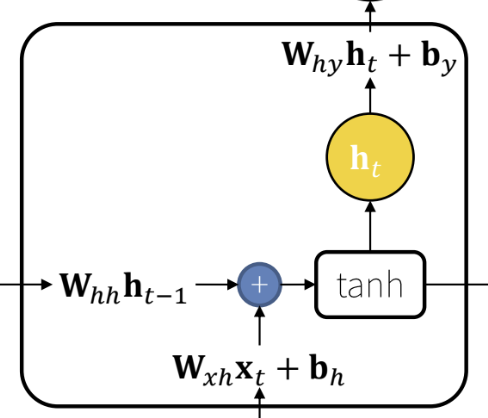

- RNN cell

In [67]:
# torch.nn.RNNCell 생성
rnn_cell = torch.nn.RNNCell(input_size=x_size, hidden_size=hidden_size)

In [68]:
# forward 1 step과 동일한 포워드 결과를 얻기 위해 pytorch가 rnn을 생성하면서
# 초기화 한 weight 값을 앞서 만들어논 weight들로 바꿔치기
rnn_cell.weight_ih.data = torch.tensor(Wxh).float()
rnn_cell.bias_ih.data = torch.tensor(bh.reshape(-1)).float()
rnn_cell.weight_hh.data = torch.tensor(Whh).float()
rnn_cell.bias_hh.data = torch.zeros(hidden_size).float()

In [69]:
x_torch.shape

torch.Size([1, 5])

In [70]:
# torch.nn.RNN은 다음처럼 출력을 되돌림
#
# ho: tensor of shape (N, Hout)

h_torch = rnn_cell(x_torch, hprev_torch)
h_torch

tensor([[-0.9981, -0.9085, -0.4038, -0.9996,  0.9994, -0.9409,  0.9972,  0.9939,
         -0.9147, -0.9996]], grad_fn=<TanhBackward0>)

In [71]:
# 직접 계산한것과 RNNcell을 사용하여 계산한 값의 차이 확인
# -> 차이가 없다
with np.printoptions(precision=6, suppress=True):
    print(h - h_torch.detach().numpy())

[[ 0. -0. -0.  0.  0.  0.  0.  0.  0. -0.]]


## Forward N steps

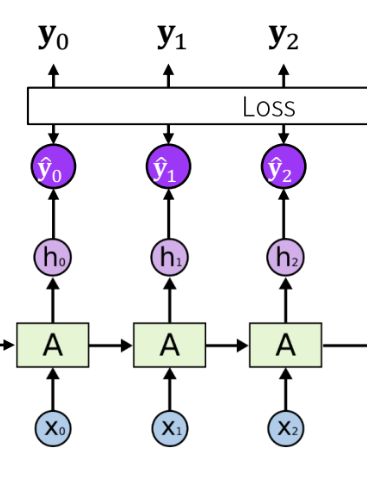

In [72]:
# 입력이 다섯개인 경우에 대해서 순차적으로 루프를 돌면서
# RNN cell을 포워드 시키기
# 이를 위해 x는 (step, x_size)으로 만들고
# 각 행마다 한자리만 1이고 나머지는 0인 원핫벡터로 만든다.
step = 3
x = np.zeros((step, x_size))

#########################################
# zeros로 초기화된 x에 적당한 위치를 1로 바꾸기
# hint: np.random.choice()사용한 어레이 인덱싱
x[np.arange(step), np.random.choice(x.shape[1], step)] = 1
print(f"x: {x_size}-dim. vector, {step} step ")
print(x)
##########################################

# 이전 상태 벡터 초기화
hprev = np.random.random((1, hidden_size))
print(f"hprev: {hidden_size}-dim.")
print(hprev)

# 정답벡터 초기화
# step만큼 입력되는 각 x에 매치되는 정답 인덱스 0 ~ y_size-1
y = np.random.choice(y_size, step)
print(f"y: label of {y_size}-dim.")
print(y)


x: 5-dim. vector, 3 step 
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
hprev: 10-dim.
[[0.7641 0.8962 0.6689 0.2208 0.4377 0.57   0.111  0.5283 0.1052 0.0296]]
y: label of 15-dim.
[1 6 0]


### 직접 포워드

In [73]:
# 입력 x와 이전상태 hprev를 입력받고
# step만큼 루프를 돌면서 나오는 결과를 output에 쌓아서 되돌리는
# 함수를 작성
# 반환할 값
#  h:마지막 출력, (hidden_size,1)
#  output: 모든 스탭에서 출력을 저장한 어레이, (hidden_size, step)
def simple_rnn(x, hprev, Whh, Wxh, bh):
    output = []

    h = hprev

    for t in range(x.shape[0]):
        ########################################################
        # WRITE YOUR CODE HERE
        # [1] t 스탭에 해당하는 열을 뽑아내어 xt에 저장
        # x:(3,5) -> xt:(1,5)
        xt = x[[t], :]

        # [2] 뽑아낸 열 xt를 포워드 시킨다.
        # np.tanh까지 적용한 결과를 h에 저장
        prev = np.dot(h, Whh.T)
        hraw = np.dot(xt, Wxh.T) + bh + prev
        h = np.tanh(hraw)

        # [3] 계산된 h벡터를 output에 append한다.
        output.append(h)

    return np.concatenate(output), h # [(1,10), (1,10), (1,10)] -> (3,10)


In [74]:
# 포워드 시키기
# 위 셀이 제대로 코딩되었다면 출력은 output:(20,5), h:(20,1)가 되며
# 마지막 출력 h가 output의 마지막 열로 들어있어야 함
output, h = simple_rnn(x, hprev, Whh, Wxh, bh)
print('h.shape:', h.shape, 'output.shape:', output.shape)

print('output')
print(output)

print('h')
print(h)

h.shape: (1, 10) output.shape: (3, 10)
output
[[-0.9892  0.991  -0.6601  0.9881 -0.691   0.9871  0.9981 -0.8379 -0.9472  0.9536]
 [ 0.7534  0.9775 -0.996  -0.9999 -0.9998 -0.9999  0.9679  0.989  -0.5812 -1.    ]
 [-0.9711 -0.9569  1.      0.9757  0.8497  0.9126 -0.9999 -0.1989 -1.      0.8798]]
h
[[-0.9711 -0.9569  1.      0.9757  0.8497  0.9126 -0.9999 -0.1989 -1.      0.8798]]


#### 출력과 손실

In [75]:
# output을 y로 변환
y_pred = np.dot(output, Why.T) + by
y_pred

array([[ 1.7545,  0.07  ,  3.0339,  1.14  ,  1.9448,  0.4685, -1.0132,  4.0809,  3.0708,  0.4294, -3.6355,  0.7897, -3.2592,  2.0655, -1.5701],
       [ 5.1619, -1.644 , -4.0182, -0.3588,  9.2127,  0.7082, -0.2693, -3.1705, -0.7326, -0.8103,  4.4538,  1.5902, -2.5971, -2.8437,  4.454 ],
       [-0.62  , -1.1551,  7.9888, -3.5016, -5.4885,  1.3123, -0.4232,  3.3774, -4.6438,  1.1885, -2.6352, -3.4993, -0.5461,  4.6623, -7.3816]])

In [76]:
# softmax 적용
y_pred = np.exp(y_pred) / np.exp(y_pred).sum(axis=1).reshape(-1,1)
y_pred

array([[4.3670e-02, 8.1024e-03, 1.5697e-01, 2.3623e-02, 5.2826e-02, 1.2070e-02, 2.7428e-03, 4.4721e-01, 1.6287e-01, 1.1607e-02, 1.9924e-04,
        1.6641e-02, 2.9025e-04, 5.9600e-02, 1.5716e-03],
       [1.6812e-02, 1.8614e-05, 1.7327e-06, 6.7296e-05, 9.6569e-01, 1.9560e-04, 7.3599e-05, 4.0446e-06, 4.6305e-05, 4.2846e-05, 8.2804e-03,
        4.7255e-04, 7.1762e-06, 5.6078e-06, 8.2823e-03],
       [1.7396e-04, 1.0187e-04, 9.5330e-01, 9.7499e-06, 1.3369e-06, 1.2013e-03, 2.1180e-04, 9.4734e-03, 3.1113e-06, 1.0614e-03, 2.3188e-05,
        9.7721e-06, 1.8731e-04, 3.4241e-02, 2.0135e-07]])

In [77]:
# softmax 적용 확인, 다 더하면 모두 1이 나와야 함
y_pred.sum(axis=1)

array([1., 1., 1.])

In [78]:
# 현재 예측에서 확률이 제일 큰 자리의 인덱스
y_pred_idx = np.argmax(y_pred, axis=1)

# 이 값을 미리 정답으로 만들어논 타겟과 비교
y_pred_idx
# 가중치를 모두 무작위로 설정했으므로, 모두 틀림

array([7, 4, 2])

In [79]:
# 미리 설정해놓은 타겟값과 y_pred_idx는
# 완전히 다르므로 로스를 계산하면 높게 나와야 함.
# 로스 계산 negative log likelihood
# 정답자리 마이너스 로그값

nll = -np.log(y_pred[np.arange(step), y])
nll

array([4.8156, 9.5169, 8.6567])

In [80]:
# 평균 로스
nll.mean()

7.663054644071312

In [81]:
# 만약 무작위로 출력한 자리수가 다 정답이라고 가정하면
y_test = y_pred_idx

In [82]:
# 로스가 줄어든다.
nll = -np.log(y_pred[np.arange(step), y_test])
nll.sum() / step

0.29581825491367997

### torch.nn.RNNCell N steps

In [83]:
# 같은 입력으로 시작하기
print(f"x: {x_size}-dim. vector, {step} step ")
# step : 샘플 하나에 들어있는 스탭 수
# ex : "i love you"가 하나의 샘플, "i", "love", "you" 3개의 스텝으로 구성
# (N, L, D) : N문장은 L개의 스텝으로 구성, 한 스텝은 5개의 길이
print(x)
print(f"hprev: {hidden_size}-dim.")
print(hprev)

x: 5-dim. vector, 3 step 
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
hprev: 10-dim.
[[0.7641 0.8962 0.6689 0.2208 0.4377 0.57   0.111  0.5283 0.1052 0.0296]]


In [84]:
output = []

x_torch = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=0) # (Batch size, Time step, Sample size)
print('x_torch.shape', x_torch.shape)

hprev_torch = torch.tensor(hprev, dtype=torch.float32) # (Batch size, Hidden size)
print('hprev_torch.shape', hprev_torch.shape)
h = hprev_torch

x_torch.shape torch.Size([1, 3, 5])
hprev_torch.shape torch.Size([1, 10])


In [85]:
# 입력의 모양이 예를 들어 샘플 2개, 10 타임스탭, 한 타임스탭에 데이터가 길이 5 벡터라고 가정하고
# 다음처럼 임의로 입력을 만들고
foo = torch.rand((2,10,5))
print(foo)

# 0번 타임스탭만 뽑으면 결과는 (2, 5)
print(foo[:,0,:])
foo[:,0,:].shape

tensor([[[0.4884, 0.3387, 0.2637, 0.3695, 0.3708],
         [0.1739, 0.4556, 0.7614, 0.7367, 0.8939],
         [0.6719, 0.4967, 0.9440, 0.1976, 0.4859],
         [0.9557, 0.4997, 0.7072, 0.5239, 0.0077],
         [0.9151, 0.6107, 0.6133, 0.4146, 0.8398],
         [0.2837, 0.2181, 0.6996, 0.2358, 0.1300],
         [0.1626, 0.7916, 0.4025, 0.2979, 0.8741],
         [0.5821, 0.8942, 0.5585, 0.8792, 0.8475],
         [0.9432, 0.5826, 0.4164, 0.1798, 0.9544],
         [0.6281, 0.3846, 0.8425, 0.2387, 0.4945]],

        [[0.8335, 0.4664, 0.8069, 0.9029, 0.4527],
         [0.4726, 0.7522, 0.0798, 0.0982, 0.0018],
         [0.7990, 0.9300, 0.5294, 0.8976, 0.7555],
         [0.3547, 0.3640, 0.6954, 0.9234, 0.4608],
         [0.2635, 0.8961, 0.1616, 0.8020, 0.4985],
         [0.4758, 0.9811, 0.1231, 0.9818, 0.1116],
         [0.1016, 0.4489, 0.5498, 0.7135, 0.3456],
         [0.2743, 0.9874, 0.3273, 0.6860, 0.4649],
         [0.4003, 0.1748, 0.7653, 0.9695, 0.4537],
         [0.6160, 0.1696, 0.9

torch.Size([2, 5])

In [86]:
for t in range(x_torch.shape[1]):
    ########################################################
    # WRITE YOUR CODE HERE
    # [1] t 스탭에 해당하는 열을 뽑아내어 xt에 저장
    xt = x_torch[:,t,:] # (Batch size, Sample size)

    # [2] 뽑아낸 열 xt를 포워드 시킨다.
    h = rnn_cell(xt, h)

    # [3] 계산된 h벡터를 output에 append한다.
    output.append(h.detach().numpy()) # (1,10)

output = np.concatenate(output) # [(1,10), (1,10), (1,10)] -> (3,10)
h = h.detach().numpy()

In [87]:
# 제대로 계산되었다면 다음처럼 출력되어야 함
# h.shape: (1, 10) output.shape: (3, 10)
print('h.shape:', h.shape, 'output.shape:', output.shape)

# 이 output, h는 simple_rnn()함수로 만든 output과 동일해야 함
print('output')
print(output)

print('h')
print(h)

# 위에 직접 계산하여 나온 출력 결과와 동일

h.shape: (1, 10) output.shape: (3, 10)
output
[[-0.9892  0.991  -0.6601  0.9881 -0.691   0.9871  0.9981 -0.8379 -0.9472  0.9536]
 [ 0.7534  0.9775 -0.996  -0.9999 -0.9998 -0.9999  0.9679  0.989  -0.5812 -1.    ]
 [-0.9711 -0.9569  1.      0.9757  0.8497  0.9126 -0.9999 -0.1989 -1.      0.8798]]
h
[[-0.9711 -0.9569  1.      0.9757  0.8497  0.9126 -0.9999 -0.1989 -1.      0.8798]]


### torch.nn.RNN

- 파이토치는 앞서 직접 만들어본 `simple_rnn` 함수와 `torch.nn.RNNCell`을 `for`루프 돌리면서 포워드시킨 방식과 완전히 동일하게 작동하는 `torch.nn.RNN`을 제공

In [88]:
# 같은 입력으로 시작하기
print(f"x: {x_size}-dim. vector, {step} step ")
print(x)
print(f"hprev: {hidden_size}-dim.")
print(hprev)

x: 5-dim. vector, 3 step 
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
hprev: 10-dim.
[[0.7641 0.8962 0.6689 0.2208 0.4377 0.57   0.111  0.5283 0.1052 0.0296]]


In [89]:
# numpy array를 torch.nn.RNN에 입력하기 위해 tensor로 바꾸기
x_torch = torch.tensor(x).float()
hprev_torch = torch.tensor(hprev).float()

In [90]:
# torch.nn.RNN 생성
rnn = torch.nn.RNN(input_size=x_size,
                   hidden_size=hidden_size,
                   batch_first=True)
                   # RNN으로 생성되는 형태 (N, L, D)
                   # 실제로 torch.nn.RNN는 (T, N, D) 형태임
                   # 배치사이즈(N)를 앞으로 보냄
                   # 라이브러리 만든 사람들이 신기하게 만듦...


In [ ]:
# simple_rnn()과 동일한 포워드 결과를 얻기 위해 pytorch가 rnn을 생성하면서
# 초기화 한 weight 값을 앞서 만들어논 weight들로 바꿔치기

rnn.weight_ih_l0.data = torch.tensor(Wxh).float()
rnn.bias_ih_l0.data = torch.tensor(bh.reshape(-1)).float()
rnn.weight_hh_l0.data = torch.tensor(Whh).float()
rnn.bias_hh_l0.data = torch.zeros(hidden_size).float()


In [ ]:
# 현재 입력의 모양 확인하기
print(x_torch.shape)
print(hprev_torch.shape)

torch.Size([3, 5])
torch.Size([1, 10])


In [ ]:
# torch.nn.RNN은 다음처럼 입력을 받음
#
# input: tensor of shape (N, L, Hin): (Batch size, Time step, Sample size)
# h0: tensor of shape (D*num_layer, N, Hout): (RNN 진행 방향 수*적층 레이어수, Batch size, Output size), default zeros
# D*num_layer RNN도 여러개 적층 가능, '나는 너를 사랑해', '사랑해 나는 너를'..
# 일단 잘 이해가 안가도 넘어갈것.

# 입력 모양을 맞추기 위해 배치 차원을 더함
x_torch_reshape = x_torch.unsqueeze(dim=0)
hprev_torch_reshape = hprev_torch.unsqueeze(dim=0)

In [ ]:
print(x_torch_reshape.shape)
print(hprev_torch_reshape.shape)

torch.Size([1, 3, 5])
torch.Size([1, 1, 10])


In [ ]:
# torch.nn.RNN은 다음처럼 출력을 되돌림
#
# output: tensor of shape (N, L, D*Hout): (Batch size, Time step, RNN 진행 방향 수*Output size)
# hn: tensor of shape (D*num_layer, N, Hout): (RNN 진행 방향 수*Output size, Batch size, Output size)
output, hn = rnn(x_torch_reshape, hprev_torch_reshape)

In [ ]:
print(output.shape)
print(hn.shape)

torch.Size([1, 3, 10])
torch.Size([1, 1, 10])


In [ ]:
# simple_rnn()의 출력과 결과를 비교 하기 위해 적당히 모양을 되돌림
# 결과를 출력해서 simple_rnn()과 동일한지 확인
print(output)
print(hn)

tensor([[[-0.9892,  0.9910, -0.6601,  0.9881, -0.6910,  0.9871,  0.9981,
          -0.8379, -0.9472,  0.9536],
         [ 0.7534,  0.9775, -0.9960, -0.9999, -0.9998, -0.9999,  0.9679,
           0.9890, -0.5812, -1.0000],
         [-0.9711, -0.9569,  1.0000,  0.9757,  0.8497,  0.9126, -0.9999,
          -0.1989, -1.0000,  0.8798]]], grad_fn=<TransposeBackward1>)
tensor([[[-0.9711, -0.9569,  1.0000,  0.9757,  0.8497,  0.9126, -0.9999,
          -0.1989, -1.0000,  0.8798]]], grad_fn=<StackBackward0>)


#### 출력과 손실

In [ ]:
# output을 y로 변환
y_pred = torch.mm(output[0], torch.tensor(Why.T).float()) + torch.tensor(by).float()
print(y_pred.shape)
y_pred

torch.Size([3, 15])


tensor([[ 1.7545,  0.0700,  3.0339,  1.1400,  1.9448,  0.4685, -1.0132,  4.0809,
          3.0708,  0.4294, -3.6355,  0.7897, -3.2592,  2.0655, -1.5701],
        [ 5.1619, -1.6440, -4.0182, -0.3588,  9.2127,  0.7082, -0.2693, -3.1705,
         -0.7326, -0.8103,  4.4538,  1.5902, -2.5971, -2.8437,  4.4540],
        [-0.6200, -1.1551,  7.9888, -3.5016, -5.4885,  1.3123, -0.4232,  3.3774,
         -4.6438,  1.1885, -2.6352, -3.4993, -0.5461,  4.6623, -7.3816]],
       grad_fn=<AddBackward0>)

In [ ]:
# torch.nn.functoinal.nll_loss를 써서 로스 확인
# nll_loss에서 input:(N,C), target:(N,)
# 먼저 타겟 y를 사용
torch.nn.functional.nll_loss(
    torch.log_softmax(y_pred, dim=1),
    torch.LongTensor(y)
)

tensor(7.6631, grad_fn=<NllLossBackward0>)

In [ ]:
# torch.nn.functoinal.nll_loss를 써서 로스 확인
# nll_loss에서 input:(N,C), target:(N,)
# 타겟 y_test를 사용
torch.nn.functional.nll_loss(
    torch.log_softmax(y_pred, dim=1),
    torch.LongTensor(y_test)
)

tensor(0.2958, grad_fn=<NllLossBackward0>)